In [223]:
import pandas as pd
import numpy as np
import crawler as crawler
%reload_ext autoreload
%autoreload 2
import json
import pickle
import matplotlib.pyplot as plt

In [2]:
df_mov = pd.read_table('../data/movie.metadata.tsv', header=None)

In [135]:
df_mov.head(3)

,0,1,2,3,4,5,6,7,8,time,year,details,credits,ids,revenue,budget
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,2001,"{'adult': False, 'backdrop_path': '/anSbunnEMI...","[{'adult': False, 'gender': 1, 'id': 57395, 'k...","{'id': 10016, 'imdb_id': 'tt0228333', 'wikidat...",14010832,28000000
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000-02-16,2000,"{'adult': False, 'backdrop_path': None, 'belon...",<NA>,"{'id': 784579, 'imdb_id': 'tt0245916', 'wikida...",<NA>,<NA>
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988-01-01,1988,"{'adult': False, 'backdrop_path': '/6nGFaOiHOo...","[{'adult': False, 'gender': 2, 'id': 1014342, ...","{'id': 396302, 'imdb_id': 'tt0094806', 'wikida...",<NA>,<NA>


## Crawling
Nearly 90% of revenue entries are missing

In [3]:
sum(df_mov[4].isna())/len(df_mov)

0.8972241592346558

### Preprocessing

In [5]:
# Changing date format to Datetime and filling in NA values
filler = pd.to_datetime('2040-01-01')
df_mov['time'] = pd.to_datetime(df_mov[3], errors='coerce', format='mixed')
df_mov['time'].fillna(filler, inplace=True)
df_mov['year'] = df_mov['time'].apply(lambda x: int(x.year))

# Create new, empty columns
df_mov.loc[:,['details', 'credits','ids']] = np.nan

### Crawling (Multithread)

In [10]:
# Split the dataframe into chunks
chunk_size = 6000
chunks = [(i, min(i + chunk_size, len(df_mov))) for i in range(1000, len(df_mov), chunk_size)]

# Use ThreadPoolExecutor to run the process_chunk function in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(lambda args: process_chunk(*args), chunks)

C:\Users\benkr\AppData\Local\Temp\ipykernel_16472\2831211354.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_mov.loc[i, 'details'] = str(details)
C:\Users\benkr\AppData\Local\Temp\ipykernel_16472\2831211354.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_mov.loc[i, 'credits'] = str(credits)
C:\Users\benkr\AppData\Local\Temp\ipykernel_16472\2831211354.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_mov.loc[i, 'ids'] = str(ids)


iteration: 31000iteration: 7000  details:  None  ids:  None
  details:  None  ids:  None
iteration: 43000  details:  None  ids:  None
iteration: 19000  details:  None  ids:  None
iteration: 67000  details:  None  ids:  None
iteration: 49000  details:  {'adult': False, 'backdrop_path': None, 'belongs_to_collection': None, 'budget': 0, 'genres': [{'id': 28, 'name': 'Action'}], 'homepage': '', 'id': 76969, 'imdb_id': 'tt2084939', 'original_language': 'ta', 'original_title': 'சிவப்பதிகாரம்', 'overview': "A man is working on a project with a smart professor whose daughter starts to like the man. During the legislature elections some mysterious killings take place. It's up to the guy to trace the killer.", 'popularity': 2.157, 'poster_path': '/kJgnNe912Jrn0FyrP6wEXu1gjFW.jpg', 'production_companies': [{'id': 124777, 'logo_path': None, 'name': 'Screen Play Entertainment', 'origin_country': ''}], 'production_countries': [], 'release_date': '2006-11-24', 'revenue': 0, 'runtime': 135, 'spoken_la

### Crawling (Missing)

In [41]:
missings = df_mov[df_mov['credits'].isna()].copy(deep=False)

In [39]:
for i in missings.index:
    name = df_mov.loc[i,2]
    year = df_mov.loc[i,'year']
    try:
        details, credits, ids = get_movie(name, year)
        df_mov.loc[i,'details'] = str(details)
        df_mov.loc[i,'credits'] = str(credits)
        df_mov.loc[i,'ids'] = str(ids)

        if not (i % 100):
            print(f"iteration: {i}"," details: ", details, " ids: ", ids)
        if not (i % 1000):
            with open(f"crawling_{i}.obj",'wb') as file:
                pickle.dump(df_mov, file)
    except Exception as error:
        print(f'iteration: {i}, error: {error}')

iteration: 0  details:  {'adult': False, 'backdrop_path': '/anSbunnEMI0TSmizqUSRACoe18l.jpg', 'belongs_to_collection': None, 'budget': 28000000, 'genres': [{'id': 28, 'name': 'Action'}, {'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}], 'homepage': 'http://www.theofficialjohncarpenter.com/ghost-of-mars/', 'id': 10016, 'imdb_id': 'tt0228333', 'original_language': 'en', 'original_title': 'Ghosts of Mars', 'overview': 'In 2176, a Martian police unit is sent to pick up a highly dangerous criminal at a remote mining post. Upon arrival, the cops find the post deserted and something far more dangerous than any criminal — the original inhabitants of Mars, hellbent on getting their planet back.', 'popularity': 17.683, 'poster_path': '/i2zztssCIbahGES1fdfWFmDXian.jpg', 'production_companies': [{'id': 51312, 'logo_path': None, 'name': 'Animationwerks', 'origin_country': ''}, {'id': 3287, 'logo_path': '/bz6GbCQQXGNE56LTW9dwgksW0Iw.png', 'name': 'Screen Gems', 'origin_country': 

## Cleanup & Extraction

In [85]:
# Fill in pd.NA instead of None (change initial function if reused)
# df_mov['details'] = df_mov.loc[:,'details'].apply(lambda x: changeNA(x))
# df_mov['credits'] = df_mov.loc[:,'credits'].apply(lambda x: changeNA(x))
# df_mov['ids'] = df_mov.loc[:,'ids'].apply(lambda x: changeNA(x))

In [117]:
# Extract Budget & Revenue
df_mov['budget'] = df_mov.loc[:,'details'].apply(lambda x: extractBudget(x))
df_mov['revenue_TMBD'] = df_mov.loc[:,'details'].apply(lambda x: extractRevenue(x))
df_mov['revenue_TMBD'] = df_mov.loc[:,'revenue'].apply(lambda x: zeroToNA(x))

In [152]:
# combine revenues from TMDB and given Dataset
tmdb = df_mov['revenue_TMDB'].fillna(0)
existing = df_mov[4].fillna(0)
df_mov['revenue'] = tmdb.combine(existing, max)
df_mov['revenue'] = df_mov['revenue'].replace(0,None)

In [145]:
# getting genres
df_mov['genres'] = df_mov[8].apply(lambda x: list(eval(x).values()) if x else [])

In [207]:
# getting crew
df_mov[['actors','crew','directors']] = df_mov['credits'].apply(lambda x: crawler.extractRoles(x))


In [224]:
#getting production companies
df_mov['production_companies'] = df_mov['details'].apply(lambda x: crawler.extractProductionCompanies(x))

In [236]:
# get rating and votes
df_mov[['rating','votes']] = df_mov['details'].apply(lambda x: crawler.extractPopularityRating(x))

5.125 982
8.0 1
0.0 0
5.742 64
5.3 13
6.0 1
4.6 11
6.6 23
0.0 0
6.5 133
5.0 7
6.3 102
3.8 6
7.21 333
7.444 27
7.571 4374
0.0 0
6.0 1
6.4 5
5.236 104
5.8 7
6.7 16
0.0 0
6.841 22
5.0 1
7.157 277
2.0 1
7.2 16
5.0 3
4.871 31
4.5 2
5.3 5
0.0 0
6.8 11
7.0 2
7.5 23
4.4 22
7.4 28
5.656 33
0.0 0
7.231 1036
5.5 4
7.07 192
5.449 69
0.0 0
6.0 7
7.668 95
7.1 23
0.0 0
6.112 147
5.5 4
6.5 19
4.917 12
6.924 33
8.5 23
6.2 6
4.303 33
4.0 1
5.855 44
0.0 0
6.363 585
3.8 2
0.0 0
5.0 3
0.0 0
6.3 3
6.2 15
6.8 15
7.0 8
5.0 4
5.833 6
5.307 70
0.0 0
5.474 19
6.11 86
6.828 195
0.0 0
5.556 9
6.0 14
5.1 16
6.0 10
6.074 27
5.1 5
3.9 17
8.667 6
4.0 1
4.9 7
4.5 2
4.8 99
6.483 30
6.5 6
7.5 6
5.3 3
4.5 8
7.092 450
6.914 29
5.7 14
6.464 124
1.0 1
6.278 9
6.7 56
5.5 11
5.1 34
7.163 129
5.7 14
7.0 10
6.488 339
6.7 12
6.294 321
6.8 199
6.4 23
8.5 2
0.0 0
6.091 11
7.0 2
3.7 5
5.667 257
5.714 14
6.8 10
3.0 2
4.0 1
0.0 0
3.7 3
7.698 666
0.0 0
7.0 31
0.0 0
5.2 3
4.364 11
6.0 4
6.0 1
0.0 0
5.8 3
6.192 308
7.146 851
4.0 1
7.91 6

In [232]:
eval(df_mov.loc[64785,'details']).get('vote_average')

6.129

In [214]:
df_mov.head()

,0,1,2,3,4,5,6,7,8,time,...,revenue,budget,prod_country,revenue_TMDB,revenue_combined,genres,actors,crew,directors,production_companies
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,14010832,28000000,US,14010832,14010832,"[Thriller, Science Fiction, Horror, Adventure,...","[Natasha Henstridge, Ice Cube, Pam Grier, Jaso...",[Damon Caro],[],"[Animationwerks, Screen Gems, Storm King Produ..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000-02-16,...,None,<NA>,US,<NA>,0,"[Mystery, Biographical film, Drama, Crime Drama]",[],[],[],[]
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988-01-01,...,None,<NA>,NO,<NA>,0,"[Crime Fiction, Drama]","[Frank Krog, Kristin Kajander, Anne Krigsvoll,...",[],[],"[Filmeffekt AS, Norsk Film]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987-01-01,...,None,<NA>,GB,<NA>,0,"[Thriller, Erotic thriller, Psychological thri...","[David Keith, Cathy Moriarty, Alan Rosenberg, ...",[],[],[Mrs. White's Productions]
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983-01-01,...,None,<NA>,DE,<NA>,0,[Drama],"[Gudrun Landgrebe, Mathieu Carrière, Hanns Zis...",[],[],[Dieter Geissler Filmproduktion]


## Results

In [127]:
new_info = df_mov.apply(lambda x: True if not pd.isnull(x['revenue_TMDB']) and (pd.isnull(x[4])) else False, axis=1)

In [128]:
print('empty details: ',sum(df_mov['details'].isna()))
print('TMDB - initial info: ',sum(df_mov['budget'].isna()) - sum(df_mov[4].isna()))
print('new info from TMDB: ', sum(new_info))


empty details:  19338
TMDB - initial info:  -1479
new info from TMDB:  3593


# Hollywood

In [129]:
df_mov['prod_country'] = df_mov.apply(lambda x: extractCountry(x), axis=1)

In [130]:
in_us = df_mov['prod_country'] == "US"
us_movies = df_mov[in_us]
us_movies.reset_index(inplace=True)
missing_revenue = us_movies['revenue'].isna()


In [134]:
us_movies.head(3)

,index,0,1,2,3,4,5,6,7,8,time,year,details,credits,ids,revenue,budget,prod_country,revenue_TMDB,revenue_combined
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,2001,"{'adult': False, 'backdrop_path': '/anSbunnEMI...","[{'adult': False, 'gender': 1, 'id': 57395, 'k...","{'id': 10016, 'imdb_id': 'tt0228333', 'wikidat...",14010832,28000000,US,14010832,14010832
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000-02-16,2000,"{'adult': False, 'backdrop_path': None, 'belon...",<NA>,"{'id': 784579, 'imdb_id': 'tt0245916', 'wikida...",<NA>,<NA>,US,<NA>,0
2,5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913-05-29,1913,"{'adult': False, 'backdrop_path': None, 'belon...","[{'adult': False, 'gender': 2, 'id': 1086663, ...","{'id': 263493, 'imdb_id': 'tt0002894', 'wikida...",<NA>,<NA>,US,<NA>,0


(array([0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 1.300e+01,
        1.900e+01, 5.400e+01, 1.080e+02, 1.190e+02, 1.090e+02, 1.230e+02,
        4.270e+02, 3.200e+02, 1.190e+02, 1.520e+02, 1.780e+02, 2.390e+02,
        4.920e+02, 7.880e+02, 8.450e+02, 9.920e+02, 1.092e+03, 1.450e+03,
        7.790e+02]),
 array([1890., 1895., 1900., 1905., 1910., 1915., 1920., 1925., 1930.,
        1935., 1940., 1945., 1950., 1955., 1960., 1965., 1970., 1975.,
        1980., 1985., 1990., 1995., 2000., 2005., 2010., 2015.]),
 <BarContainer object of 25 artists>)

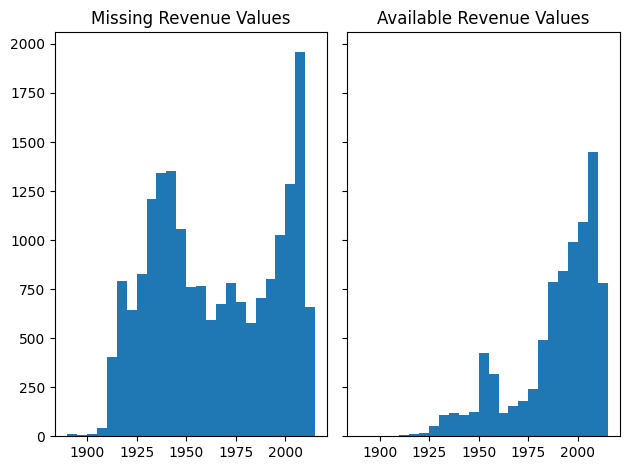

In [135]:
fig, axs = plt.subplots(1,2, sharey=True, tight_layout=False)
n_bins = range(min(us_movies['year']), max(us_movies['year']), 5)
axs[0].set_title('Missing Revenue Values')
axs[0].hist(us_movies[missing_revenue]['year'], bins= n_bins)
axs[1].set_title('Available Revenue Values')
axs[1].hist(us_movies[~missing_revenue]['year'], bins= n_bins)

### Investigating peak around 2005-2010 to find ways to get more data

In [99]:
new_us_movie = us_movies.apply(lambda x : x['year'] in range(2005,2010), axis=1)

In [103]:
new_movies = us_movies[new_us_movie]

# Saving

In [124]:
# Save df for later
with open(f"crawling.obj",'wb') as file:
    pickle.dump(df_mov, file)

In [35]:
with open('crawling.obj', 'rb') as file:
    df_mov = pickle.load(file)